# Create an ensemble forecast using dropout

The atmosphere is an inherently chaotic system. This means that even tiny errors in the initial conditions can cause large errors in the forecast even if a perfect model existed. Check out the famous [butterfly effect](https://en.wikipedia.org/wiki/Lorenz_system). But in addition to this, we have unknown model uncertainties in weather models.

What this means in essence is that we really need a large number of possible forecasts, what is called an ensemble, for a given weather situation to create a probabilistic forecast. This then allows us to say that there is a 30% chance of rain. For physical weather forecasts, these ensembles are created by using slightly different initial conditions and model physics.

What I am trying to do in the WeatherBench project is to create a purely data-driven forecast. For this we created a benchmark dataset. Check out the [paper](http://arxiv.org/abs/2002.00469). So far, in the benchmark and in my experiments I have only trained deterministic models, that is models that produce a single, "best" forecast. But as mentioned above, ideally we would produce a range of possible forecasts. The big question is how to do this with deep learning.

I see several possible methods:

1. Train a bunch of different models (e.g. different random seed or different hyperparameters)
1. Use different initial conditions.
1. If the model uses dropout, use dropout also during inference to introduce randomness.
1. Use a parametric approach: Forecast a PDF, e.g. a Gaussian, by predicting the paramters, e.g. mean and standard deviation. See some work I've done on this: https://doi.org/10.1175/MWR-D-18-0187.1
1. Use a GAN.

I have no idea which method works best, so we need to try it out.

I thought an easy place to start is to test the test-time dropout method. You task in this notebook is to implement this based on a model I already trained. BTW, this paper proposed the method: https://arxiv.org/pdf/1506.02142.pdf
 
So let's get started.

## Set up

This is my development branch of WeatherBench, which means things are not as nicely documented. Sorry about that. Regardless, let's import the modules we need. If you don't know what a function or class does, check out the definition in the `src` directory. Also check the requirements in the `environment.yml` file.

In [ ]:
#notes:
#xarray: https://rabernat.github.io/research_computing_2018/xarray.html
#to-do: make both predictions (deterministic and probabilistic) working with correct version of tensorflow. error: eager executionn
#to-do: make rank histogram instead of normal histogram (pip install rank-histogram)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from src.utils import *
from src.score import *
from src.data_generator import *
from src.networks import *
import matplotlib.pyplot as plt

/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
/anaconda3/lib/python3.7/site-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will

In [3]:
tf.__version__

'1.14.0'

In [ ]:
# You only need this if you are using a GPU
#os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
#limit_mem()

## Load the data

We are using the benchmark dataset. It comes in three different resolutions, for now I am just using the lowest resolution: 5.625 degrees. Download instructions can be found here: https://github.com/pangeo-data/WeatherBench. The entire dataset for this resolution takes up around 200GB. Since this is quite a lot I uploaded a single year of the data you need here: http://doi.org/10.5281/zenodo.3700685. In `test.zip`.

In [4]:
datadir = '/Users/sagar/Library/Mobile\ Documents/com~apple~CloudDocs/studies/WeatherBench/Testing_WeatherBench/test/'# Change this to where you downloaded the data

In [5]:
!ls $datadir

13-mean.nc                     geopotential
13-resnet_bn_dr_0.1.h5         temperature
13-resnet_bn_dr_0.1_weights.h5 u_component_of_wind
13-std.nc                      v_component_of_wind
constants


These are all the parameters for the model and data generator that I use for the `train_nn.py` script.

In [6]:
exp_id = '13-resnet_bn_dr_0.1'
var_dict = {'geopotential': ('z', [200, 500, 850]), 'temperature': ('t', [200, 500, 850]), 
            'u_component_of_wind': ('u', [200, 500, 850]), 'v_component_of_wind': ('v', [200, 500, 850]), 
            'constants': ['lsm','orography','lat2d']}  
#our input data has 'levels'. is that geopotential height?  
#why just 3 constants, not 5
output_vars = ['z_500', 't_850']
filters = [128, 128, 128, 128, 128, 128, 128, 128, 2]
kernels = [7, 3, 3, 3, 3, 3, 3, 3, 3]
lead_time = 72 #read. just above an hour. we are gonna subsample data by hour?
lr = 0.5e-4
early_stopping_patience = 10
reduce_lr_patience = 5
data_subsample = 2
norm_subsample = 30000
bn_position = 'post'
use_bias = 1
dropout = 0.1  # This is the important one

batch_size = 32
nt_in = 1
l2 = 0
skip = True

The raw data is stored in the NetCDF format. I am using the awesome [xarray](http://xarray.pydata.org/en/stable/) package to read and manipulate the data.

In [7]:
#ds = xr.merge([xr.open_mfdataset('../test/{var}/*.nc', combine='by_coords') for var in var_dict.keys()]) 
df1=xr.open_mfdataset('../test/geopotential/*.nc', combine='by_coords') 
df2=xr.open_mfdataset('../test/temperature/*.nc', combine='by_coords') 
df3=xr.open_mfdataset('../test/u_component_of_wind/*.nc', combine='by_coords') 
df4=xr.open_mfdataset('../test/v_component_of_wind/*.nc', combine='by_coords')  
df5=xr.open_mfdataset('../test/constants/*.nc', combine='by_coords')  
ds=xr.merge([df1,df2,df3,df4,df5])

Importantly we also need to load the mean and standard deviations we used to normalize the data during training.

In [8]:
mean = xr.open_dataarray('../test/13-mean.nc')
std = xr.open_dataarray('../test/13-std.nc')

In [9]:
mean #for just our subsampled data. 15 levels ('the constants are at level=1)':z200,z500,z850,t200 and so on.
#ds #for whole data.
#z200=1.15E5 >z500=5.4E4 >z850=1.37E4. decreases with height. Temperature increases from 217K to 274K (1degree celcius)? 
# * means dimension coordinates, i.e., x y axis. usually should be 2 only?

<xarray.DataArray 'z' (level: 15)>
array([ 1.152032e+05,  5.407185e+04,  1.374600e+04,  2.177746e+02,
        2.526253e+02,  2.743906e+02,  1.437102e+01,  6.775228e+00,
        1.410097e+00, -1.578050e-01, -4.013337e-02,  2.130935e-01,
        3.370783e-01,  3.794976e+02,  0.000000e+00])
Coordinates:
  * level        (level) int64 200 500 850 200 500 850 200 ... 200 500 850 1 1 1
    level_names  (level) object ...

In [11]:
dg_test = DataGenerator(
    ds, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
    shuffle=False, output_vars=output_vars
)

DG start 11:11:17.807280
DG normalize 11:11:17.834210
DG load 11:11:17.845901
Loading data into RAM
DG done 11:11:45.863664


In [12]:
# You can index into the data generator to obain a feature/target pair
# [batch, x, y, channel]
X, y = dg_test[0] #271 full channels. 16 in last batch
X.shape, y.shape

((32, 32, 64, 15), (32, 32, 64, 2))

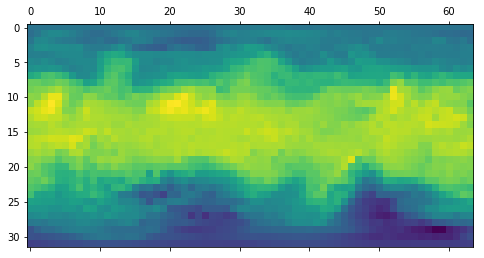

In [13]:
plt.matshow(y[0, :, :, 1]) #y[...,0] is z500 and y[...,1] is t850. normalized

# Load the model

Now let's load the pretrained model. Check the build resnet option .

In [14]:
model = build_resnet(
    filters, kernels, input_shape=(
        len(dg_test.data.lat), len(dg_test.data.lon), len(dg_test.data.level) * nt_in
    ),
    bn_position=bn_position, use_bias=use_bias, l2=l2, skip=skip,
    dropout=dropout
)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [15]:
model.compile('adam', 'mse')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 64, 15)] 0                                            
__________________________________________________________________________________________________
periodic_conv2d (PeriodicConv2D (None, 32, 64, 128)  94208       input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 64, 128)  0           periodic_conv2d[0][0]            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 64, 128)  512         activation[0][0]                 
______________________________________________________________________________________________

In [16]:
model.load_weights('../test/13-resnet_bn_dr_0.1_weights.h5')

## Create a deterministic prediction

The model has been trained to create a deterministic prediction. For this dropout is turned off during test time. Let's create a prediction for the first sample. Thanks to Tensorflow 2 we can tread the model as a function just like in PyTorch.

In [34]:
pred = model(X[:1]).numpy().squeeze(); pred.shape; #added tf.enable_eager_execution() in src/networks.py line6. have to remove if you want to run ensemble prediction :(.

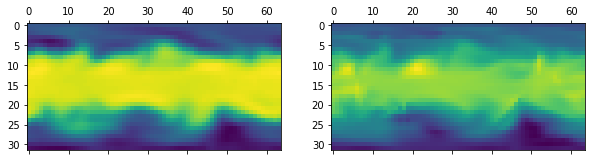

In [35]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred[..., 0]) #z500 normalized
ax2.matshow(pred[..., 1]) #t850 normalized


Task: Can you figure out what is plotted in these two images? Hint: Check out what is happening in the data generator.
Answer: z500, t850 normalized. BUt why? in create_predictions() function, dont we unnormalize them?

## Create an ensemble using test-time dropout

Now it's your turn. The pretrained model contains several dropout layers which are only active during training. Your job is to turn dropout on during inference as well. This should result in a model that creates a slightly different prediction every time. Hint: Google "Keras test-time dropout".

In [17]:
##weirdly this function works when tf.enable_eager_execution() is diabled.
#but 'pred' for single determinstic works when tf.enable_eager_execution() is enabled. 
#might be issue with tensorflow version. couldn't solve right now.

#keras switches off test time dropout by default. we could either switch it on permanently.. by putting somewhere an argument training=true). this will put both training and testing to use dropout
#but since we have a pre trained model, better just to activate dropout in testing rather than training again. beware: we also activate bacthnorm or any other that was inactive in test phase by default.
#https://stackoverflow.com/questions/52756283/adding-dropout-to-testing-inference-phase
from tensorflow.keras import backend as K
func = K.function(model.inputs + [K.learning_phase()], model.outputs)

In [18]:
# to use dropout in testing phase, pass 1 to set the learning phase to training mode
outputs = func([X[:1]] + [1.]) #for a single sample. #gives a new prediction each time.
#reshape
pred2 = np.asarray(outputs, dtype=np.float32).squeeze(); print(pred2.shape)
#outputs

(32, 64, 2)


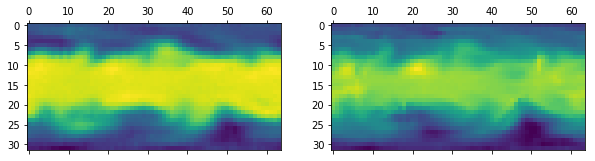

In [19]:
# Look at the predictions
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred2[..., 0]) #z500 normalized
ax2.matshow(pred2[..., 1]) #t850 normalized

Once you have a model with test-time dropout on, create a bunch of forecasts (an ensemble) for the same input. Then pick one point on the map (bonus points if you pick the point closes to Munich!) and create a histogram of the temperature ensemble predictions.

Next, remember that the features and targets were normalized inside the data generator. Can you recover the real units (Kelvin). This could be a little tricky, so no worries if you can't figure it out on your own) but if you check out the `create_predictions` function in `src/data_generator`, you will find the answer.

In [29]:
number_of_forecasts=100 #what is ideal?
pred2_ensemble=np.ndarray(shape=(number_of_forecasts,32,64,2),dtype=np.float32)
print(pred2_ensemble.shape)
forecast_counter=np.zeros(number_of_forecasts,dtype=int)

for i in range(number_of_forecasts):
    outputs = func([X[:1]] + [1.]) #new prediction each time for same sample.
    pred2 = np.asarray(outputs, dtype=np.float32).squeeze()
    pred2_ensemble[i,:,:,:]=pred2
    forecast_counter[i]=i+1
    
##pred2_ensemble[:,0,0,1] is t850

(100, 32, 64, 2)


In [30]:
#normalize
pred2_ensemble=pred2_ensemble* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values
print(pred2_ensemble[:,0,0,1]) #t850

[255.50990006 254.10401384 256.04465724 255.11065869 255.88504589
 252.11065259 254.91732837 254.54221094 255.72018453 254.76543585
 253.75398211 255.40055857 255.38316329 255.90123516 255.39379395
 253.51829954 254.67930005 256.3048954  254.36811236 254.18065493
 255.37645357 254.36332809 254.84434128 255.53735234 255.37300594
 254.7596065  256.38941056 254.78431355 255.16697941 255.06220258
 254.50719318 253.61532158 254.85577468 254.36862354 254.33014301
 253.79357776 255.37451298 255.45575469 255.03606043 255.17910196
 256.20740951 254.49921498 255.23566124 255.44725774 255.33148863
 256.0802335  254.77395173 256.0663294  254.67892898 256.21600491
 254.46622302 254.07247022 254.09202193 254.30087888 256.2711537
 256.48536669 255.62222911 254.32175776 255.11341907 254.1350406
 255.47554495 254.28254454 253.88842824 255.02311621 255.17910575
 256.53072733 256.22462682 253.9057156  255.27560714 255.0469145
 255.01427847 254.59625785 254.9557521  254.66054731 255.55175816
 252.89263744

In [ ]:
#was trying to implement a rank histogram. couldn't. simply made a histogram
# #!pip install git+https://github.com/oliverangelil/rankhistogram.git
# !pip install rank-histogram

# from ranky import rankz

# #observation
# obs=ds.t.isel(lat=lat_munich,lon=lon_munich).sel(level=850) #what should be observation size? i am taking data at all 8760 values available.
# obs=np.asarray(obs, dtype=np.float32)
# obs.shape

# #ensemble
# ensemble=pred2_ensemble[:,lat_munich,lon_munich,1]
# ensemble.shape

# #mask
# #mask = np.random.randint(0, 2, 8760)
# mask=np.ones(8760)

# # feed into rankz function
# result = rankz(obs, ensemble, mask)

# # plot histogram
# plt.bar(range(1,ensemble.shape[0]+2), result[0])

# # view histogram
# plt.show()

The predictions of the model are pure numpy arrays. Maybe you find it helpful to convert them to an xarray Dataarray with coordinates.

In [31]:
#converting from numpy to xarray
z500=xr.DataArray(pred2_ensemble[...,0],dims=['forecast_number','lat','lon'],coords={'forecast_number':forecast_counter,'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
t850=xr.DataArray(pred2_ensemble[...,1],dims=['forecast_number','lat','lon'],coords={'forecast_number':forecast_counter,'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
pred2_ensemble=xr.Dataset(data_vars={'z500': (('forecast_number','lat','lon'),z500),
                                    't850':(('forecast_number','lat','lon'),t850)},
                          coords={'forecast_number':forecast_counter,'lat':dg_test.data.lat,'lon':dg_test.data.lon})
pred2_ensemble

<xarray.Dataset>
Dimensions:          (forecast_number: 100, lat: 32, lon: 64)
Coordinates:
  * forecast_number  (forecast_number) int64 1 2 3 4 5 6 ... 95 96 97 98 99 100
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, lat, lon) float64 5.063e+04 ... 4.894e+04
    t850             (forecast_number, lat, lon) float64 255.5 255.9 ... 248.5

(array([ 4., 11., 10., 21., 15., 14., 13.,  6.,  3.,  3.]),
 array([270.18618014, 270.88797165, 271.58976316, 272.29155466,
        272.99334617, 273.69513768, 274.39692919, 275.0987207 ,
        275.80051221, 276.50230372, 277.20409523]),
 <a list of 10 Patch objects>)

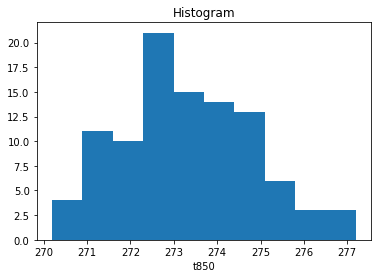

In [32]:
lat_munich=48.13743; lon_munich=11.57549 #find point closest to munich
pred2_ensemble.t850.sel(lat=lat_munich, lon=lon_munich, method='nearest').plot.hist()
#so the most likely prediction is 272.29K

(array([ 5.,  5.,  5., 14., 19., 13.,  8., 14.,  9.,  8.]),
 array([52556.99694853, 52740.28442274, 52923.57189694, 53106.85937114,
        53290.14684534, 53473.43431955, 53656.72179375, 53840.00926795,
        54023.29674215, 54206.58421636, 54389.87169056]),
 <a list of 10 Patch objects>)

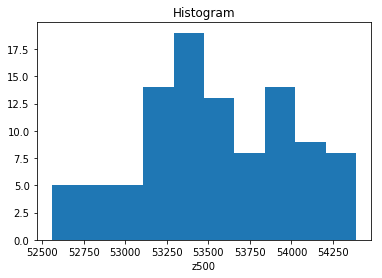

In [33]:
pred2_ensemble.z500.sel(lat=lat_munich, lon=lon_munich, method='nearest').plot.hist()


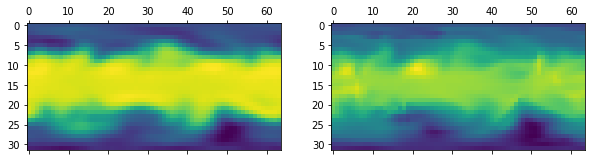

In [34]:
#plotting mean graph for all lat,lon
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.matshow(pred2_ensemble.z500.mean('forecast_number')) #z500 
ax2.matshow(pred2_ensemble.t850.mean('forecast_number')) #t850 
#behaviour similar to deterministic prediction

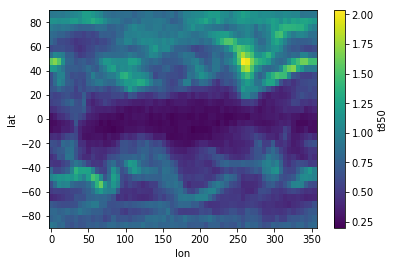

In [35]:
#plotting std
pred2_ensemble.t850.std('forecast_number').plot()
#we see ensemble predictions are better at upto 20 degree latitude. 
#Because there is a sharp drop in temperature from tropics to temperate zones?